In [23]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint

# Constants
DATA_DIR = "C:/Users/madar/OneDrive/Desktop/Dataset"
IMG_SIZE = (64, 64)
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 10

# Function to load and preprocess data
def load_data(data_dir):
    X = []
    y = []

    max_frames = 100  # Maximum number of frames per video

    for label, category in enumerate(["newnonviolent", "new_violent"]):
        category_dir = os.path.join(data_dir, category)
        for filename in os.listdir(category_dir):
            video_path = os.path.join(category_dir, filename)
            frames, num_frames = extract_frames(video_path)
            if frames:
                # Pad or trim frames to ensure a fixed length
                frames = frames[:max_frames] + [np.zeros_like(frames[0])] * (max_frames - len(frames))
                X.append(frames)
                y.append(label)

    return np.array(X), np.array(y)

# Function to extract frames from video
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)  # Resize each frame to the specified size
        frames.append(frame)
    cap.release()
    cv2.destroyAllWindows()
    return frames, num_frames

# Load the data
X, y = load_data(DATA_DIR)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Further split train data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, random_state=42)

# Model creation
max_frames = 100  # Maximum number of frames per video

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(max_frames, IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Checkpoint to save the best model
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpoint])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 245.3722 - accuracy: 0.7465 
Epoch 1: val_accuracy improved from -inf to 0.84507, saving model to best_model.h5
27/27 [==============================] - 494s 18s/step - loss: 245.3722 - accuracy: 0.7465 - val_loss: 0.6167 - val_accuracy: 0.8451
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.8856 
Epoch 2: val_accuracy improved from 0.84507 to 0.93427, saving model to best_model.h5
27/27 [==============================] - 489s 18s/step - loss: 0.5584 - accuracy: 0.8856 - val_loss: 0.3512 - val_accuracy: 0.9343
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.9717 
Epoch 3: val_accuracy improved from 0.93427 to 0.94836, saving model to best_model.h5
27/27 [==============================] - 488s 18s/step - loss: 0.2674 - accuracy: 0.9717 - val_loss: 0.3018 - val_accuracy: 0.9484
Epoch 4/10
27/27 [==============================] - ETA: 0s - l

In [2]:
import cv2
import numpy as np
from keras.models import load_model
# Load the trained model
model = load_model("best_model.h5")

In [30]:
import cv2
import numpy as np
from keras.models import load_model

# Constants
IMG_SIZE = (64, 64)
max_frames = 100  # Maximum number of frames per video

# Function to preprocess input video
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frames.append(frame)
    cap.release()
    cv2.destroyAllWindows()
    
    # Pad or trim frames to ensure a fixed length
    frames = frames[:max_frames] + [np.zeros_like(frames[0])] * (max_frames - len(frames))
    
    # Convert frames to numpy array and expand dimensions
    frames = np.array(frames)
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    return frames

# Load the trained model
model = load_model("best_model.h5")

# Function to predict violence/non-violence from input video
def predict_violence(video_path):
    # Preprocess the input video
    input_video = preprocess_video(video_path)
    
    # Predict violence/non-violence
    prediction = model.predict(input_video)
    
    # Convert prediction to human-readable label
    if prediction[0] > 0.5:
        return "Violent"
    else:
        return "Non-Violent"

# Path to the input video
input_video_path = "C:/Users/madar/OneDrive/Desktop/ankit.mp4"

# Predict violence/non-violence
prediction = predict_violence(input_video_path)
print("Prediction:", prediction)


1/1 [==============================] - 0s 144ms/step
Prediction: Non-Violent


9/9 [==============================] - 13s 1s/step - loss: 0.3069 - accuracy: 0.9737
Test Loss: 0.3069150447845459
Test Accuracy: 0.9736841917037964
9/9 [==============================] - 13s 1s/step


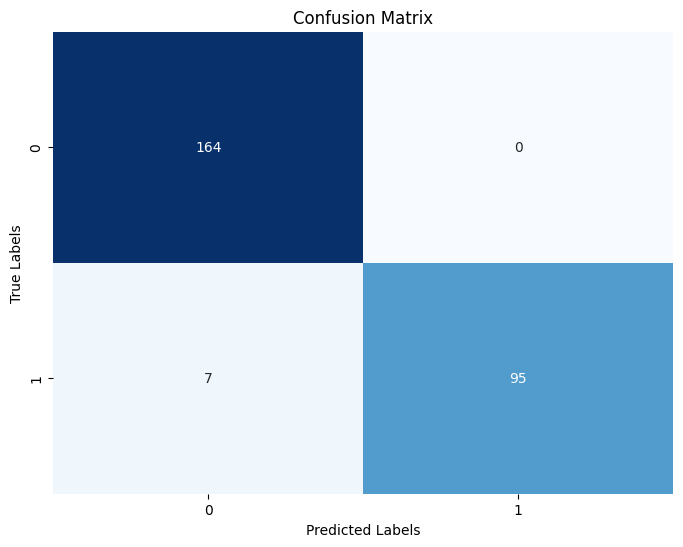

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       164
           1       1.00      0.93      0.96       102

    accuracy                           0.97       266
   macro avg       0.98      0.97      0.97       266
weighted avg       0.97      0.97      0.97       266



In [6]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Constants
DATA_DIR = "C:/Users/madar/OneDrive/Desktop/Dataset"
IMG_SIZE = (64, 64)
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 10

# Function to load and preprocess data
def load_data(data_dir):
    X = []
    y = []

    max_frames = 100  # Maximum number of frames per video

    for label, category in enumerate(["newnonviolent", "new_violent"]):
        category_dir = os.path.join(data_dir, category)
        for filename in os.listdir(category_dir):
            video_path = os.path.join(category_dir, filename)
            frames, num_frames = extract_frames(video_path)
            if frames:
                # Pad or trim frames to ensure a fixed length
                frames = frames[:max_frames] + [np.zeros_like(frames[0])] * (max_frames - len(frames))
                X.append(frames)
                y.append(label)

    return np.array(X), np.array(y)

# Function to extract frames from video
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)  # Resize each frame to the specified size
        frames.append(frame)
    cap.release()
    cv2.destroyAllWindows()
    return frames, num_frames

# Load the data
X, y = load_data(DATA_DIR)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Further split train data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, random_state=42)

# Load the model
model = load_model("best_model.h5")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predictions on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification report
print(classification_report(y_test, y_pred))
